# Środowiska ciągłe
### Katarzyna Stępień, Alicja Wójcik, Kacper Stankiewicz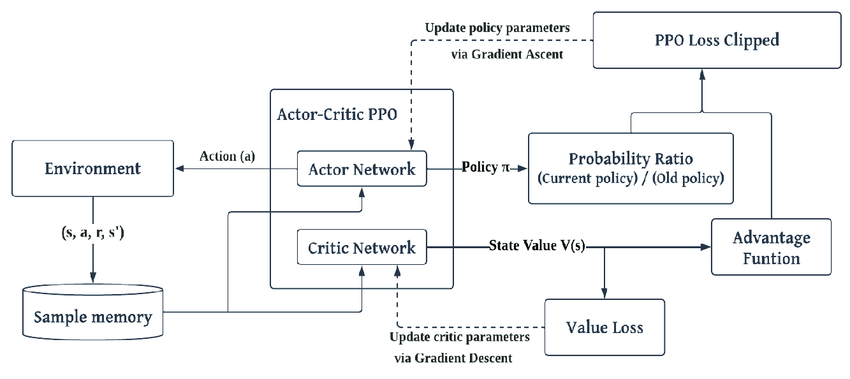

In [2]:
# for autoformatting
# %load_ext jupyter_black

In [3]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev libgles1 libglu1-mesa
  libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libice-dev libopengl-dev libsm-dev
  libxfont2 libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libice-doc libsm-doc libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev libgles1
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libice-dev libopengl-dev
  libsm-dev libxfont2 libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 25 newly installed, 0 to remove and 45 not upgraded.
Need t

## Ważniejsze biblioteki

In [4]:
import gymnasium as gym
import numpy as np

In [5]:
from stable_baselines3 import PPO

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
from stable_baselines3.ppo.policies import MlpPolicy
from gymnasium import Env
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.evaluation import evaluate_policy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
from typing import Dict
from dataclasses import dataclass, asdict, field

In [8]:
import matplotlib.pyplot as plt
import time

## Uczenie modelu

W projekcie wykorzystaliśmy ciągłą wersję środowiska MountainCar.

MDP Mountain Car to deterministyczne środowisko Markowa (MDP) 2D, w którym umieszczony jest samochód na dole sinusoidalnej doliny. Jedyne dostępne akcje to przyspieszenia, które można zastosować do samochodu w dwóch dostępnych kierunkach (przód-tył samochodu). Celem MDP jest strategiczne przyspieszenie samochodu, tak, aby osiągnąć stan docelowy na szczycie prawego wzgórza. W bibliotece Gymnasium istnieją dwie wersje tego środowiska: jedna z dyskretnymi akcjami i druga z ciągłymi. Wersja użyta w tym projekcie korzysta z ciągłych akcji.

In [9]:
env = gym.make("MountainCarContinuous-v0")

Do usprawnienia manipulacji hiperparametrów stworzyliśmy klasę pomocniczą, z domyślnymi wartościami parametrów ustawionymi według rekomendacji [repozytorium RL Zoo](https://github.com/DLR-RM/rl-baselines3-zoo)

In [10]:
@dataclass
class Params:
  normalize_advantage: bool = True
  policy: str = "MlpPolicy"
  batch_size: int = 32
  n_steps: int = 32
  gamma: float = 0.9999
  learning_rate: float = float(7.77e-05)
  ent_coef: float = 0.00429
  clip_range: float = 0.1
  n_epochs: int = 100
  gae_lambda: float = 0.9
  max_grad_norm: int = 5
  vf_coef: float = 0.19
  use_sde: bool = True
  policy_kwargs: Dict = field(default_factory=lambda: dict(log_std_init=-3.29, ortho_init=False))

W bibliotece stable_baselines dostępna jest już wyspecjalizowana funkcja do ewaluacji efektów uczenia modelu. Na potrzeby zadania wykorzystaliśmy ją do zbierania statystyk.

In [11]:
def evaluate_and_plot(model: BaseAlgorithm, env: Env, n_eval_episodes: int, warn: bool, deterministic:bool, repeat: int):
  rewards = []
  std_rewards = []
  total_time = 0
  for i in range(repeat):
    start_time = time.time()
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes, deterministic)
    end_time = time.time() - start_time
    rewards.append(mean_reward)
    std_rewards.append(std_reward)
    print(f"Iteration: {i+1}, Evaluation time: {end_time}")
    total_time += end_time
  print(f"Total evaluation time: {total_time}")

  plt.figure(figsize=(10, 5))  # Set the figure size
  fig, ax = plt.subplots(1, 2)
  y, x = zip(*[(reward, index) for index, reward in enumerate(rewards)])

  ax[0].plot(list(x), list(y), "-b", label="mean reward")
  ax[1].plot(list(x), std_rewards, "-r", label="std deviation")
  ax[0].legend(loc="upper left")
  ax[1].legend(loc="upper left")

  plt.xlabel('Episode')

  plt.title('Rewards per Episode - Mountain cart continuous PPO')
  plt.savefig('rewards_plot_ppo.png')
  plt.show()


### Wizualizacja uczenia - nagranie wideo


In [12]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [13]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Do "nagrania" wideo wykorzystany został wrapper VecVideoRecorder.

In [14]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

## Uczenie modelu wraz z wizualizacją statystyk oraz nagranie zachowania agenta




In [15]:
def create_model_and_evaluate(params, env, learning_steps, repeat, policy_kwargs = None, filename = "ppo-mountain-car", deterministic=False):
  merged_dict = asdict(params) | {"env": env}
  if policy_kwargs is not None:
    merged_dict = merged_dict | {"policy_kwargs": policy_kwargs}

  model = PPO(**merged_dict)

  start_time = time.time()
  model.learn(total_timesteps=learning_steps)
  end_time = time.time() - start_time
  print(f"Total learning time: {end_time}")

  evaluate_and_plot(model, env, n_eval_episodes=100, warn=False, deterministic=deterministic, repeat=repeat)

  record_video("MountainCarContinuous-v0", model, video_length=2000, prefix=filename)

  return model

### Parametry domyślne

Total learning time: 964.52192902565


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Iteration: 1, Evaluation time: 97.12970042228699
Iteration: 2, Evaluation time: 96.52595376968384
Iteration: 3, Evaluation time: 95.56754612922668
Iteration: 4, Evaluation time: 96.63423943519592
Iteration: 5, Evaluation time: 93.83592700958252
Iteration: 6, Evaluation time: 96.20539999008179
Iteration: 7, Evaluation time: 95.88828825950623
Iteration: 8, Evaluation time: 102.23027038574219
Iteration: 9, Evaluation time: 97.6297881603241
Iteration: 10, Evaluation time: 96.18467330932617
Total evaluation time: 967.8317868709564


<Figure size 1000x500 with 0 Axes>

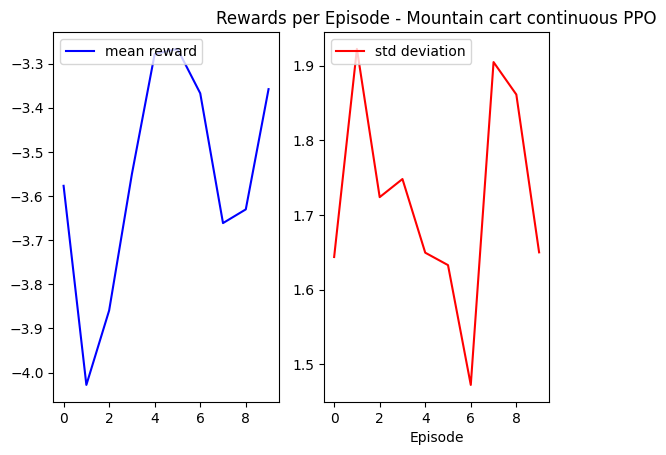

Saving video to /content/videos/ppo-mountain-car-hipar-0-step-0-to-step-2000.mp4
Moviepy - Building video /content/videos/ppo-mountain-car-hipar-0-step-0-to-step-2000.mp4.
Moviepy - Writing video /content/videos/ppo-mountain-car-hipar-0-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-mountain-car-hipar-0-step-0-to-step-2000.mp4


In [16]:
params = Params()
model1 = create_model_and_evaluate(params, env, 50_000, 10, filename="ppo-mountain-car-hipar-0")

### Różne wariacje hiperparapmetrów

Parmetry zmienione w tym eksperymencie:
- learning_rate - Wpływa na to, jak bardzo wagi lub parametry modelu są dostosowywane w każdej iteracji

- gamma - jak daleko w przyszłość uwzględniamy nagrody

- ent_coef - W PPO współczynnik entropii wpływa na regulację entropii polityki (losowość akcji)

- gae_lambda - GAE to metoda szacowania funkcji przewagi w uczeniu ze wzmocnieniem, która mierzy, o ile lepsza jest pewna akcja w porównaniu do średniej akcji

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total learning time: 1028.15846991539


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Iteration: 1, Evaluation time: 100.1697793006897
Iteration: 2, Evaluation time: 98.76645612716675
Iteration: 3, Evaluation time: 99.77699255943298
Iteration: 4, Evaluation time: 97.56717538833618
Iteration: 5, Evaluation time: 98.39455080032349
Iteration: 6, Evaluation time: 100.68726563453674
Iteration: 7, Evaluation time: 98.91120600700378
Iteration: 8, Evaluation time: 101.4163293838501
Iteration: 9, Evaluation time: 99.7118170261383
Iteration: 10, Evaluation time: 100.60262417793274
Total evaluation time: 996.0041964054108


<Figure size 1000x500 with 0 Axes>

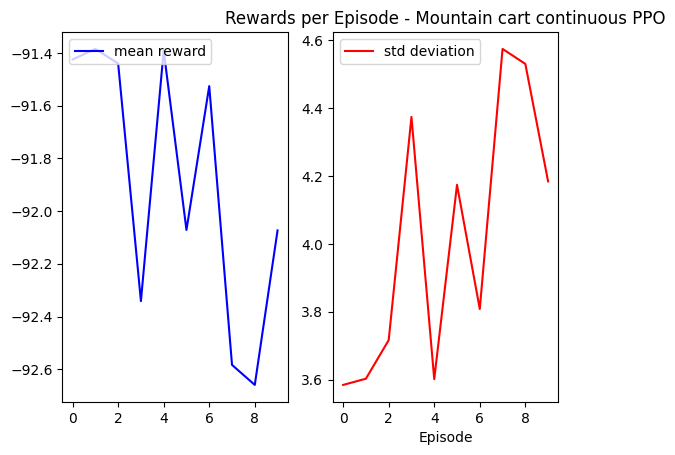

Saving video to /content/videos/ppo-mountain-car-hipar-1-step-0-to-step-2000.mp4
Moviepy - Building video /content/videos/ppo-mountain-car-hipar-1-step-0-to-step-2000.mp4.
Moviepy - Writing video /content/videos/ppo-mountain-car-hipar-1-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-mountain-car-hipar-1-step-0-to-step-2000.mp4


In [17]:
params = Params(learning_rate = float(7.77e-03), gamma=0.89, ent_coef=0.003, gae_lambda = 0.99)
model2 = create_model_and_evaluate(params, env, 50_000, 10, filename="ppo-mountain-car-hipar-1")

Parametry zmienione w tym eksperymencie:
- n_steps - ilość krków, jaką agent musi wykonać na każdy update

- vf_coef - kontroluje, jak bardzo uwzględniamy funkcję wartości w optymalizacji polityki

- clip_range - wpływa na wartość gradientu

/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 32, but because the `RolloutBuffer` is of size `n_steps * n_envs = 16`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=16 and n_envs=1)
  warnings.warn(


Total learning time: 1040.6753523349762
Iteration: 1, Evaluation time: 98.57309818267822
Iteration: 2, Evaluation time: 99.32546734809875
Iteration: 3, Evaluation time: 99.19313144683838
Iteration: 4, Evaluation time: 97.12326717376709
Iteration: 5, Evaluation time: 100.12510061264038
Iteration: 6, Evaluation time: 102.4322624206543
Iteration: 7, Evaluation time: 99.05554628372192
Iteration: 8, Evaluation time: 99.50330328941345
Iteration: 9, Evaluation time: 98.87869381904602
Iteration: 10, Evaluation time: 98.39679002761841
Total evaluation time: 992.6066606044769


<Figure size 1000x500 with 0 Axes>

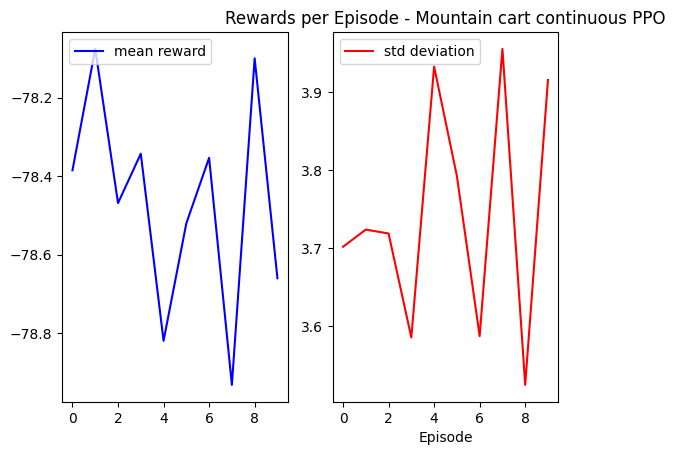

Saving video to /content/videos/ppo-mountain-car-hipar-2-step-0-to-step-2000.mp4
Moviepy - Building video /content/videos/ppo-mountain-car-hipar-2-step-0-to-step-2000.mp4.
Moviepy - Writing video /content/videos/ppo-mountain-car-hipar-2-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-mountain-car-hipar-2-step-0-to-step-2000.mp4


In [18]:
params = Params(n_steps=16, n_epochs = 50, vf_coef = 0.24, clip_range = 0.15)
model3 = create_model_and_evaluate(params, env, 50_000, 10, filename="ppo-mountain-car-hipar-2")

(Wygenerowane filmiki zostaną załączone w osobnym pliku)

In [19]:
show_videos("videos", prefix="ppo-mountain-car-hipar")

## Eksperymenty z różnymi architekturami sieci

### Domyślnie wykorzystywana sieć - MlpPolicy

**PPO** jest metodą policy gradient, co oznacza, że bezpośrednio optymalizuje politykę agenta. Funkcja polityki agenta to sieć neuronowa, która jest aktualizowana (dość powoli, w celu ograniczenia popełniania złych decyzji przez agenta, prowadzących w zupełnie innym kierunku) na podstawie rezultatów podejmowanych akcji i przyznawanych za nie nagród.

PPO zawiera w sobie dwa modele, aktora i krytyka, o dwóch różnych architekturach, co widać na obrazku niżej:

![ppo](https://drive.google.com/uc?export=view&id=1PlRHtfXZJ_iRZ1r1arA_TJSLXrcLe7Zx)

Nasza początkowa sieć wykorzystuje dwie gęste warstwy w modelu aktora oraz krytyka (jest to wartość domyślna). Wszystkie mają po 64 neurony. Funkcja aktywacji to ReLu.

![ppo64](https://drive.google.com/uc?export=view&id=1n2I87Pjq6eTTdiBRdETZbYbneooHPYxp)

### Modyfikacja 1

W tym wypadku architektura modelu aktora wygląda następująco:

![actor32](https://drive.google.com/uc?export=view&id=1bxh5-LoWJJOuBkRf_ybrWZhI_0-IxQd9)

Natomiast krytyka:

![critic1688](https://drive.google.com/uc?export=view&id=1dRZK6--kLZwciB3UbZvn6bbBnZVi4Avx)

### Modyfikacja 2

W tym wypadku architektura modelu aktora wygląda następująco:


![actor161616](https://drive.google.com/uc?export=view&id=14MBXugWXMWb6aAtkPIlVTR3Udg2Qshgb)

Natomiast krytyka:

![critic88](https://drive.google.com/uc?export=view&id=1X_OEjNFUK4d2ek3ZAUb2ip7WtvIersI_)

### Modyfikacja pierwsza

In [20]:
import torch as th

Total learning time: 21.568514823913574
Iteration: 1, Evaluation time: 95.2289879322052
Iteration: 2, Evaluation time: 92.94602108001709
Iteration: 3, Evaluation time: 95.56260085105896
Iteration: 4, Evaluation time: 94.45041108131409
Iteration: 5, Evaluation time: 95.26777577400208
Iteration: 6, Evaluation time: 96.12512969970703
Iteration: 7, Evaluation time: 95.78335547447205
Iteration: 8, Evaluation time: 94.16796231269836
Iteration: 9, Evaluation time: 95.62494421005249
Iteration: 10, Evaluation time: 94.5117974281311
Total evaluation time: 949.6689858436584


<Figure size 1000x500 with 0 Axes>

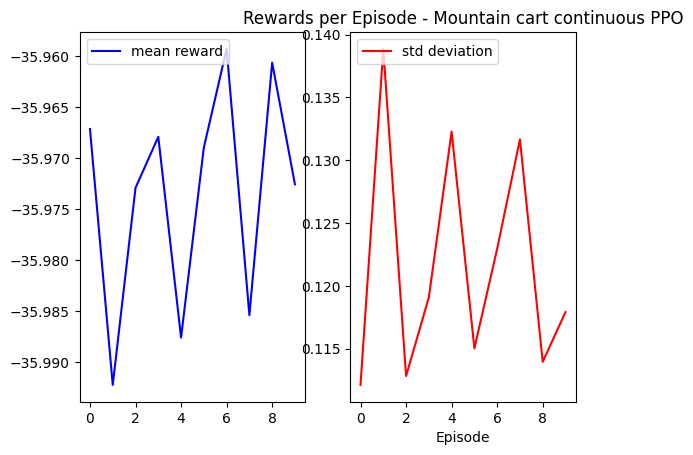

Saving video to /content/videos/ppo-mountain-car-arch-1-step-0-to-step-2000.mp4
Moviepy - Building video /content/videos/ppo-mountain-car-arch-1-step-0-to-step-2000.mp4.
Moviepy - Writing video /content/videos/ppo-mountain-car-arch-1-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-mountain-car-arch-1-step-0-to-step-2000.mp4


In [21]:
params = Params()
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[32], vf=[16, 8, 8]))
create_model_and_evaluate(params, env, 1_000, 10, policy_kwargs, filename="ppo-mountain-car-arch-1")

### Modyfikacja druga

Total learning time: 20.676827669143677
Iteration: 1, Evaluation time: 98.40177321434021
Iteration: 2, Evaluation time: 99.6122715473175
Iteration: 3, Evaluation time: 98.03056025505066
Iteration: 4, Evaluation time: 97.37879848480225
Iteration: 5, Evaluation time: 96.55198192596436
Iteration: 6, Evaluation time: 98.13795852661133
Iteration: 7, Evaluation time: 97.46470332145691
Iteration: 8, Evaluation time: 99.32774639129639
Iteration: 9, Evaluation time: 101.84903240203857
Iteration: 10, Evaluation time: 105.82809972763062
Total evaluation time: 992.5829257965088


<Figure size 1000x500 with 0 Axes>

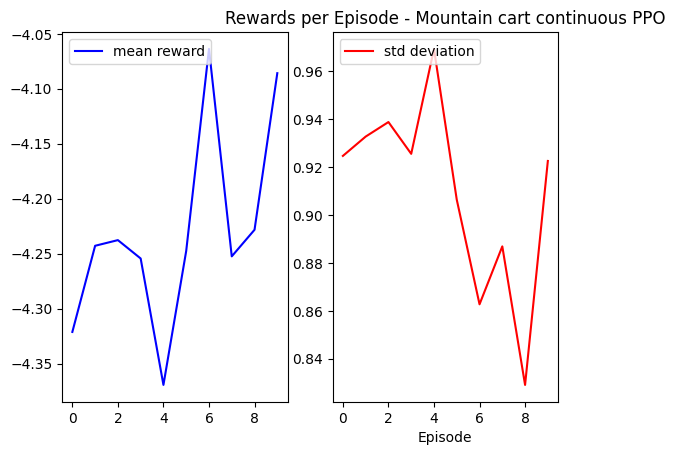

Saving video to /content/videos/ppo-mountain-car-arch-2-step-0-to-step-2000.mp4
Moviepy - Building video /content/videos/ppo-mountain-car-arch-2-step-0-to-step-2000.mp4.
Moviepy - Writing video /content/videos/ppo-mountain-car-arch-2-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-mountain-car-arch-2-step-0-to-step-2000.mp4


In [22]:
params = Params()
policy_kwargs = dict(activation_fn=th.nn.Tanh,
                     net_arch=dict(pi=[16, 16, 16], vf=[8, 8]))
create_model_and_evaluate(params, env, 1000, 10, policy_kwargs, filename="ppo-mountain-car-arch-2")

## Obserwacja zachowania agenta z wyłączonym trybem eksploracji

### Model z włączonym trybem eskploracji


Iteration: 1, Evaluation time: 100.04866027832031
Iteration: 2, Evaluation time: 100.0587739944458
Iteration: 3, Evaluation time: 98.32848525047302
Iteration: 4, Evaluation time: 98.63921856880188
Iteration: 5, Evaluation time: 99.2242865562439
Iteration: 6, Evaluation time: 99.35451483726501
Iteration: 7, Evaluation time: 98.07438588142395
Iteration: 8, Evaluation time: 98.96322226524353
Iteration: 9, Evaluation time: 98.14273285865784
Iteration: 10, Evaluation time: 100.11210870742798
Total evaluation time: 990.9463891983032


<Figure size 1000x500 with 0 Axes>

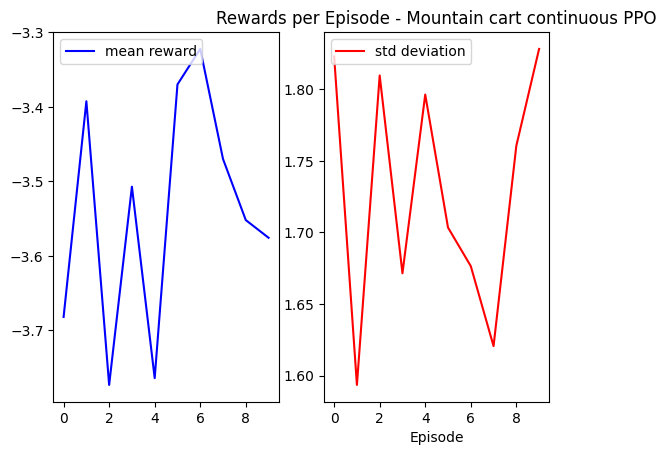

In [23]:
evaluate_and_plot(model1, env, n_eval_episodes=100, warn=False, deterministic=False, repeat=10)

### Model z wyłączonym trybem eskploracji

Iteration: 1, Evaluation time: 92.52334976196289
Iteration: 2, Evaluation time: 91.13316178321838
Iteration: 3, Evaluation time: 92.75875067710876
Iteration: 4, Evaluation time: 91.92105841636658
Iteration: 5, Evaluation time: 93.04375672340393
Iteration: 6, Evaluation time: 91.97932648658752
Iteration: 7, Evaluation time: 92.44150710105896
Iteration: 8, Evaluation time: 92.63075137138367
Iteration: 9, Evaluation time: 90.98882055282593
Iteration: 10, Evaluation time: 90.18031740188599
Total evaluation time: 919.6008002758026


<Figure size 1000x500 with 0 Axes>

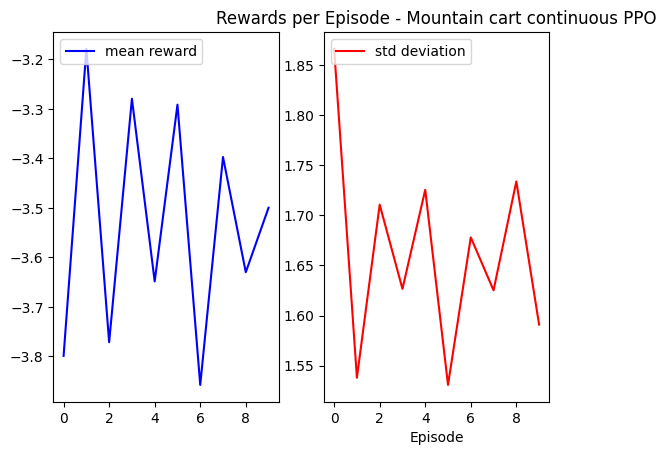

In [24]:
evaluate_and_plot(model1, env, n_eval_episodes=100, warn=False, deterministic=True, repeat=10)